<a href="https://colab.research.google.com/github/jhuee/DeepLearning/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Apr 16 01:43:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# This mounts your google drive storage to this code
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

root = '/content/gdrive/My Drive/Test/'

# root = './'
# if not os.path.exists(root):
#     os.makedirs(root)

Using cuda device


데이터 로드
네트워크 구성
loss
optimezer
train
test 순서로


In [ ]:
# settings for data normalization
# trans = transforms.Compose([transform.ToTensor(), transform.Normalize((0.5,),(1.0,))])
#기본 변환 지정
trans = transforms.ToTensor()
# trans = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()])


train_data = datasets.FashionMNIST(
    root=root,
    train=True,
    download=True,
    transform=trans,
)

test_data = datasets.FashionMNIST(
    root=root,
    train=False,
    download=True,
    transform=trans,
)

#데이터를 셔플해주는 역할, 배치 크기로 빼주는 역할
batch_size = 50
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)


In [ ]:
# Linear Classification
#init, foward 정의

class LinearClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(28*28, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

model = LinearClassification().to(device)
print(model)


LinearClassification(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


#여러개의 레이어를 쓰는 경우

In [ ]:
# # Multi-layer Perceptron
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(28*28, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
#             nn.Linear(512, 10)
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

# model = NeuralNetwork().to(device)
# print(model)


#CNN을 사용하여 convolution layer를 쌓기


In [ ]:
# define the CNN:
# two convolution layers followed by two linear layers

class MyConvNet(nn.Module):   # nn.Module should be inherited for the neural network configuration so that it can work with backpropagation APIs
    def __init__(self):    # define layers: two conv layers and two linear (fully connected) layers
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(4*4*64, 512),
            nn.Linear(512, 10)
        )

    # network connection: two conv layers, each followed by relu and max-pooling with (2x2) kernel, and two linear layer
    def forward(self, x):
        logits = self.conv_layers(x)
        return(logits)


# generate neural net model
model = MyConvNet().to(device)
print(model)


MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=512, bias=True)
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

In [ ]:
# training and test

# epoch: 10
# 이 순서는 무조건 외워둘 것
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(10):
    # training phase
    # model.train()
    current_loss= 0.0
    #x크기 (16,1,28,28) -> 16개를 병렬로 돌림.
    #target은 (16, 0~10)
    for batch_num, (x, target) in enumerate(train_loader):
        x, target = x.to(device), target.to(device)

        #FP
        out = model(x)
        loss = criterion(out,target)

        #BP
        optimizer.zero_grad() #쓰레기값들 지워줌
        loss.backward()
        optimizer.step()
        current_loss += loss

        # display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100))
            current_loss = 0.0


    # test phase
    # 미분 계산 X
    with torch.no_grad():
        # model.eval()
        total_samples = 0.0
        correct_samples = 0.0
        for (x, target) in test_loader:
            x, target = x.to(device), target.to(device)
            out = model(x)
            #제일 높은 걸로 예측
            pred = torch.argmax(out,1)
            correct_samples += (pred == target).sum() #몇 개 맞혔는지 다 더함
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))




epoch: 0, batch_num: 100, current_loss: 0.911
epoch: 0, batch_num: 200, current_loss: 0.597
epoch: 0, batch_num: 300, current_loss: 0.549
epoch: 0, batch_num: 400, current_loss: 0.495
epoch: 0, batch_num: 500, current_loss: 0.435
epoch: 0, batch_num: 600, current_loss: 0.417
epoch: 0, batch_num: 700, current_loss: 0.382
epoch: 0, batch_num: 800, current_loss: 0.372
epoch: 0, batch_num: 900, current_loss: 0.376
epoch: 0, batch_num: 1000, current_loss: 0.352
epoch: 0, batch_num: 1100, current_loss: 0.356
epoch: 0, batch_num: 1200, current_loss: 0.353
Accuracy: 87.420
epoch: 1, batch_num: 100, current_loss: 0.311
epoch: 1, batch_num: 200, current_loss: 0.324
epoch: 1, batch_num: 300, current_loss: 0.320
epoch: 1, batch_num: 400, current_loss: 0.323
epoch: 1, batch_num: 500, current_loss: 0.302
epoch: 1, batch_num: 600, current_loss: 0.321
epoch: 1, batch_num: 700, current_loss: 0.311
epoch: 1, batch_num: 800, current_loss: 0.290
epoch: 1, batch_num: 900, current_loss: 0.304
epoch: 1, batc

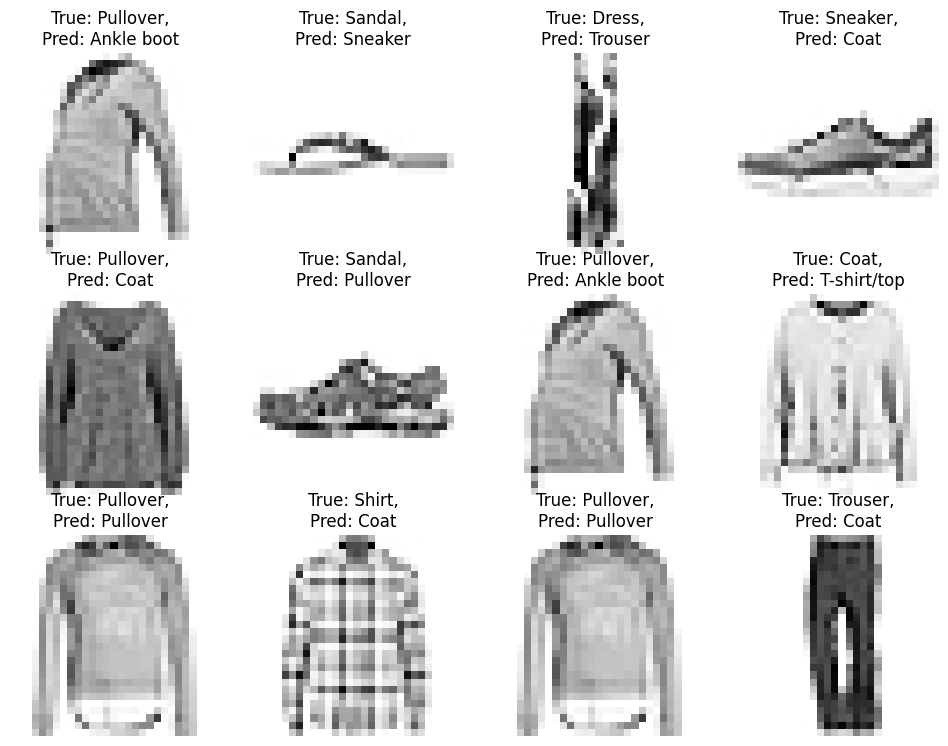

In [ ]:
# Display Some test results
import numpy as np
import matplotlib.pyplot as plt

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# take one batch of the data
test_data, test_labels = next(iter(test_loader))

# if cuda_available:
test_data, test_labels = test_data.to(device), test_labels.to(device)
out = model(test_data)              # put the test data to the trained network
pred = torch.argmax(out,1)          # prediction to the highest probability


sample_index = np.random.choice(batch_size, size=12)     # take 12 random sample index
num_samples = sample_index.size

random_samples = test_data[sample_index].cpu().numpy()

plt.figure(figsize=(12, 12))

# display test samples
for k in range(num_samples):
    plt.subplot(4, 4, k + 1)
    plt.imshow(random_samples[k].reshape(28, 28),cmap='Greys')
    plt.title("True: " + str( classes[test_labels[sample_index[k]].item()]) + ",\nPred: " + str(classes[pred[sample_index[k]].item()]))
    plt.axis('off')


plt.show()

In [ ]:
# save model
torch.save(model, root + 'my_CNN_model.pth')

# load model
# model = torch.load('my_CNN_model.pth')

In [ ]:
# # save model weights
# torch.save(model.state_dict(), 'model_weights.pth')

# # load model weights
# model = MyConvNet()
# model.load_state_dict(torch.load('model_weights.pth'))
